## **AI300 Capstone Project- T17: Onn Yun Hui**

### **1. Import Necessary Libraries Required for EDA and ML and Getting Dataframe Ready**
***

In [1]:
#pip install summarytools
#pip install Jinja2
#pip install pymysql
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from summarytools import dfSummary
import seaborn as sns 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, f1_score
import sklearn.metrics as metrics
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import joblib
from pathlib import Path
import os
import pymysql
import warnings
warnings.filterwarnings('ignore')

In [2]:
host = 'heicoders-playground.c2ced10ceyki.ap-southeast-1.rds.amazonaws.com'
port = 3306
user = 'student300'
password = 'heicoders_AI300'
database = 'ai300_capstone'

conn = pymysql.connect(
    host=host,
    port=int(port),
    user=user,
    passwd=password,
    db=database,
    charset='utf8mb4')

df = pd.read_sql_query("""
SELECT *
FROM account
INNER JOIN account_usage ON account.account_id = account_usage.account_id
INNER JOIN customer ON customer.customer_id = account.customer_id
INNER JOIN city ON city.zip_code = customer.zip_code
INNER JOIN churn_status ON account.customer_id = churn_status.customer_id
""", conn)

df.to_csv('../data/customer_churn.csv', index=False)

In [3]:
df = pd.read_csv('../data/customer_churn.csv')
df.head()

,account_id,customer_id,tenure_months,num_referrals,has_internet_service,internet_type,has_unlimited_data,has_phone_service,has_multiple_lines,has_premium_tech_support,...,zip_code.1,city,latitutde,longitude,population,customer_id.2,status,churn_label,churn_category,churn_reason
0,BFIN-DLMOA,0013-EXCHZ,3,3,Yes,Fiber Optic,Yes,Yes,No,Yes,...,93010,Camarillo,34.227846,-119.079903,42853,0013-EXCHZ,Churned,Yes,Dissatisfaction,Network reliability
1,AFEO-XOOCP,0014-BMAQU,63,8,Yes,Fiber Optic,No,Yes,Yes,Yes,...,94558,Napa,38.489789,-122.270110,63947,0014-BMAQU,Stayed,No,NaN,NaN
2,DEMQ-MFXWC,0016-QLJIS,65,3,Yes,Cable,Yes,Yes,Yes,Yes,...,95681,Sheridan,38.984756,-121.345074,1219,0016-QLJIS,Stayed,No,NaN,NaN
3,AIPP-VTDXJ,0019-EFAEP,72,0,Yes,Fiber Optic,Yes,Yes,Yes,No,...,91942,La Mesa,32.782501,-117.016110,24005,0019-EFAEP,Stayed,No,NaN,NaN
4,CJHA-SRKIB,0019-GFNTW,56,0,Yes,DSL,Yes,No,No,Yes,...,93441,Los Olivos,34.704340,-120.026090,1317,0019-GFNTW,Stayed,No,NaN,NaN


Removing duplicate columns during join tables

In [4]:
df.drop(['account_id.1', 'customer_id.1', 'zip_code.1', 'customer_id.2'], axis = 1, inplace = True)

### **2. Overview of the Dataset**
***
This information can be used for data preparation step to check shape of the dataset, the number of missing values, min, max, mean values.

In [5]:
dfSummary(df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,account_id[object],1. BFIN-DLMOA2. NEWT-UTTDQ3. GVEE-PDLRR4. ZFLT-FYMEG5. CSIJ-CHRDZ6. FGCS-PVTZI7. JPWR-GEAJQ8. TATC-XDMWI9. XHZN-DNKMN10. QTKC-XIIHW11. other,"1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)7,033 (99.9%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy80BEi2AAAACXBIWXMAAA9hAAAPYQGoP6dpAAADLklEQVR4nO3cwY3TYBRG0ecogmFja2QpJUAPKYItvdOFNzCswoIeriVzTgX/4kpPkfxleb1eA4Xb2Q/g/yE2MmIjIzYyYiMjNjJiIyM2MmIjIzYyt2VZvi3L8nb2Q7i+28x8nZnPZz+E63NGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MbWZ+zsyfsx/C9S3+xYiKM0pGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEZGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkREbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKJllZr7MzKezH8L13fd9/76u6/vZD+H67uu6vj+fz9/btn2c/Riu6ziOt/vMzLZtH4/H49fZD+La/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjc5/59/nH2Q/h2o7jeFv2ff/h40kKPgsnY11Fxg8EMmIjIzYyYiMjNjJiIyM2MmIjIzYyfwFj50uCzHpkKgAAAABJRU5ErkJggg=="">",0(0.0%)
2,customer_id[object],1. 0013-EXCHZ2. 3587-PMCOY3. 5780-INQIK4. 5707-ORNDZ5. 5288-AHOUP6. 5131-PONJI7. 5002-GCQFH8. 4854-CIDCF9. 4710-NKCAW10. 4381-MHQDC11. other,"1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)7,033 (99.9%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy80BEi2AAAACXBIWXMAAA9hAAAPYQGoP6dpAAADLklEQVR4nO3cwY3TYBRG0ecogmFja2QpJUAPKYItvdOFNzCswoIeriVzTgX/4kpPkfxleb1eA4Xb2Q/g/yE2MmIjIzYyYiMjNjJiIyM2MmIjIzYyt2VZvi3L8nb2Q7i+28x8nZnPZz+E63NGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MbWZ+zsyfsx/C9S3+xYiKM0pGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEZGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkREbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKJllZr7MzKezH8L13fd9/76u6/vZD+H67uu6vj+fz9/btn2c/Riu6ziOt/vMzLZtH4/H49fZD+La/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjc5/59/nH2Q/h2o7jeFv2ff/h40kKPgsnY11Fxg8EMmIjIzYyYiMjNjJiIyM2MmIjIzYyfwFj50uCzHpkKgAAAABJRU5ErkJggg=="">",0(0.0%)
3,tenure_months[int64],Mean (sd) : 32.4 (24.5)min < med < max:1.0 < 29.0 < 72.0IQR (CV) : 46.0 (1.3),72 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy80BEi2AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACr0lEQVR4nO3dvW7aUBiH8fdASMxHjRAtbF46VurA6KV30Ivt2i1DcgMZunRiiSJFBIQbhDF0CVWkpgEf4+A/fX5zXofhkW0O/nCbzcaAqqsd+wMA+zjb9QfOuaaZnXtuf7nZbB49Z4E/Xg3VOdfs9/tfwzDs+Wx8NptNnHPfiBVF7dqjnodh2Ivj+LHb7S7ybHg6nQZXV1e9+/v7czMjVBSy89BvZtbtdheDweCXx/abHjPAX/gyBQmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgl73dwH7KPMZ0AQKg6i7GdAECoOpdRnQBAqDqqsZ0DwZQoSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSSv0JNcuyhpmFzjnfTfBWFZhZ

It is noteworthy that in this dataset, there is no duplicated values, hence, there is no need to remove any duplicated values. 

However, there are several columns that needs to be preprocessed in the next section.

### **3. Data Cleaning and Pre-Processing**
***
Preparing the dataset for model fitting

In [6]:
# prepare a copy of data 
churn_df = df.copy()

Drop unique identifier columns columns which will not be helpful during prediction

In [7]:
churn_df.drop(['account_id', 'customer_id', 'city'], axis = 1, inplace = True)

#### **Imputation of Missing Values**


It was discovered through the summary that `internet_type` and `churn_label` contains missing values, let's check if these values corresponds and can be imputed with values from the other highly correlated columns- `has_internet_service` and `churn_label` respectively.

In [8]:
churn_na= churn_df['churn_label'].isna().sum()
print(f"The number of missing values in the 'churn_label' column is: {churn_na}")

internet_na= churn_df['internet_type'].isna().sum()
print(f"The number of missing values in the 'internet_type' column is: {internet_na}")

The number of missing values in the 'churn_label' column is: 52
The number of missing values in the 'internet_type' column is: 1526


In [9]:
churn_na= churn_df[churn_df['churn_label'].isna()]
print(f"The missing values in 'churn_label' corresponds to the values, in 'status' - {churn_na['status'].value_counts()[0]} '{churn_na['status'].value_counts().index[0]}' ")
internet_na= churn_df[churn_df['internet_type'].isna()]
print(f"The missing values in 'churn_label' corresponds to the values, in 'has_internet_service' - {internet_na['has_internet_service'].value_counts()[0]} '{internet_na['has_internet_service'].value_counts().index[0]}' ", '\n')

The missing values in 'churn_label' corresponds to the values, in 'status' - 52 'Churned' 
The missing values in 'churn_label' corresponds to the values, in 'has_internet_service' - 1526 'No'  



The when `status` is 'Churned', customer's `churn label` will be 'Yes', hence, NAN values in `churn_label` will be imputed with 'Yes'. 

Similarly, when `has internet service` is 'No', internet_type will be 'No', hence nan values in `internet_type` will be imputed with 'None'

In [10]:
churn_df['churn_label']= churn_df['churn_label'].fillna('Yes')
churn_df['churn_label'].value_counts()

churn_label
No     5174
Yes    1869
Name: count, dtype: int64

In [11]:
churn_df['internet_type']= churn_df['internet_type'].fillna('None')
churn_df['internet_type'].value_counts()

internet_type
Fiber Optic    3035
DSL            1652
None           1526
Cable           830
Name: count, dtype: int64

### **4.1 Visualisation of Dataset- General Trends**
***
For better understanding of dataset for model fitting

#### **Target Variable - `churn_label`**
Whether the customer has churned in the last month or not.

[]

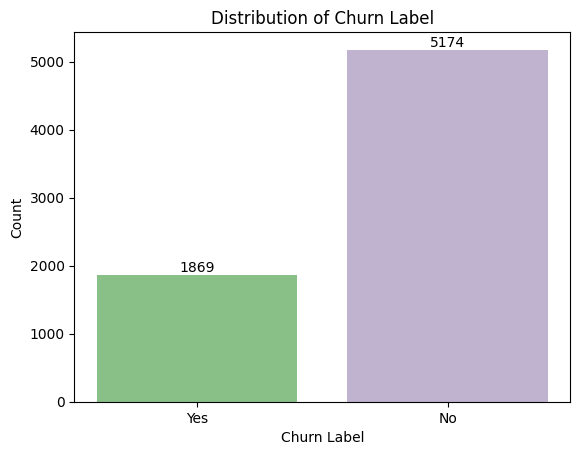

In [12]:
ax = sns.countplot(data=churn_df, x='churn_label', hue = 'churn_label', palette='Accent')

for container in ax.containers:
    ax.bar_label(container)

ax.set_xlabel('Churn Label')
ax.set_ylabel('Count')
ax.set_title('Distribution of Churn Label')
ax.plot()

It appears that this is an imbalanced data as there are more `No` labels than `Yes` labels. Hence, we will choose a more comprehensive approach to evaluate the model.

#### **`status`, `churn_category` & `churn_reason`**

To drop the rest of the columns related to the churn_label, as an existing customer prediction will never have churn status, and will lead to data leakage.

In [13]:
churn_df.drop(['status', 'churn_category', 'churn_reason'], axis = 1, inplace = True)

#### **One-Hot Encoding for Categorical Variables with 2 unique values + `payment method`**

In [14]:
encoded_df = pd.get_dummies(churn_df, 
columns= ['has_internet_service',  'has_unlimited_data', 'has_phone_service', 'has_multiple_lines', 
          'has_premium_tech_support', 'has_online_security', 'has_online_backup', 'has_device_protection', 
          'paperless_billing', 'payment_method', 'stream_tv', 'stream_movie', 'stream_music', 
          'gender', 'senior_citizen', 'married', 'churn_label'], 
          drop_first=True, dtype = int)

encoded_df.columns = [col.replace('_Yes', '') for col in encoded_df.columns]


#### **Label Encoding for Categorical Variables with >2 unique values- `internet_type` and `contract_type`**

In [15]:
internet_type_mapper = {
    'None' : 0, 
    'DSL' : 1, 
    'Cable' : 2, 
    'Fiber Optic' : 3
    }
encoded_df['internet_type'] = encoded_df['internet_type'].map(internet_type_mapper)

contract_type_mapper = {
    'Month-to-Month' : 1, 
    'One Year' : 12, 
    'Two Year' : 24
    }
encoded_df['contract_type'] = encoded_df['contract_type'].map(contract_type_mapper)

#### **Summary of Correlation of All Features**

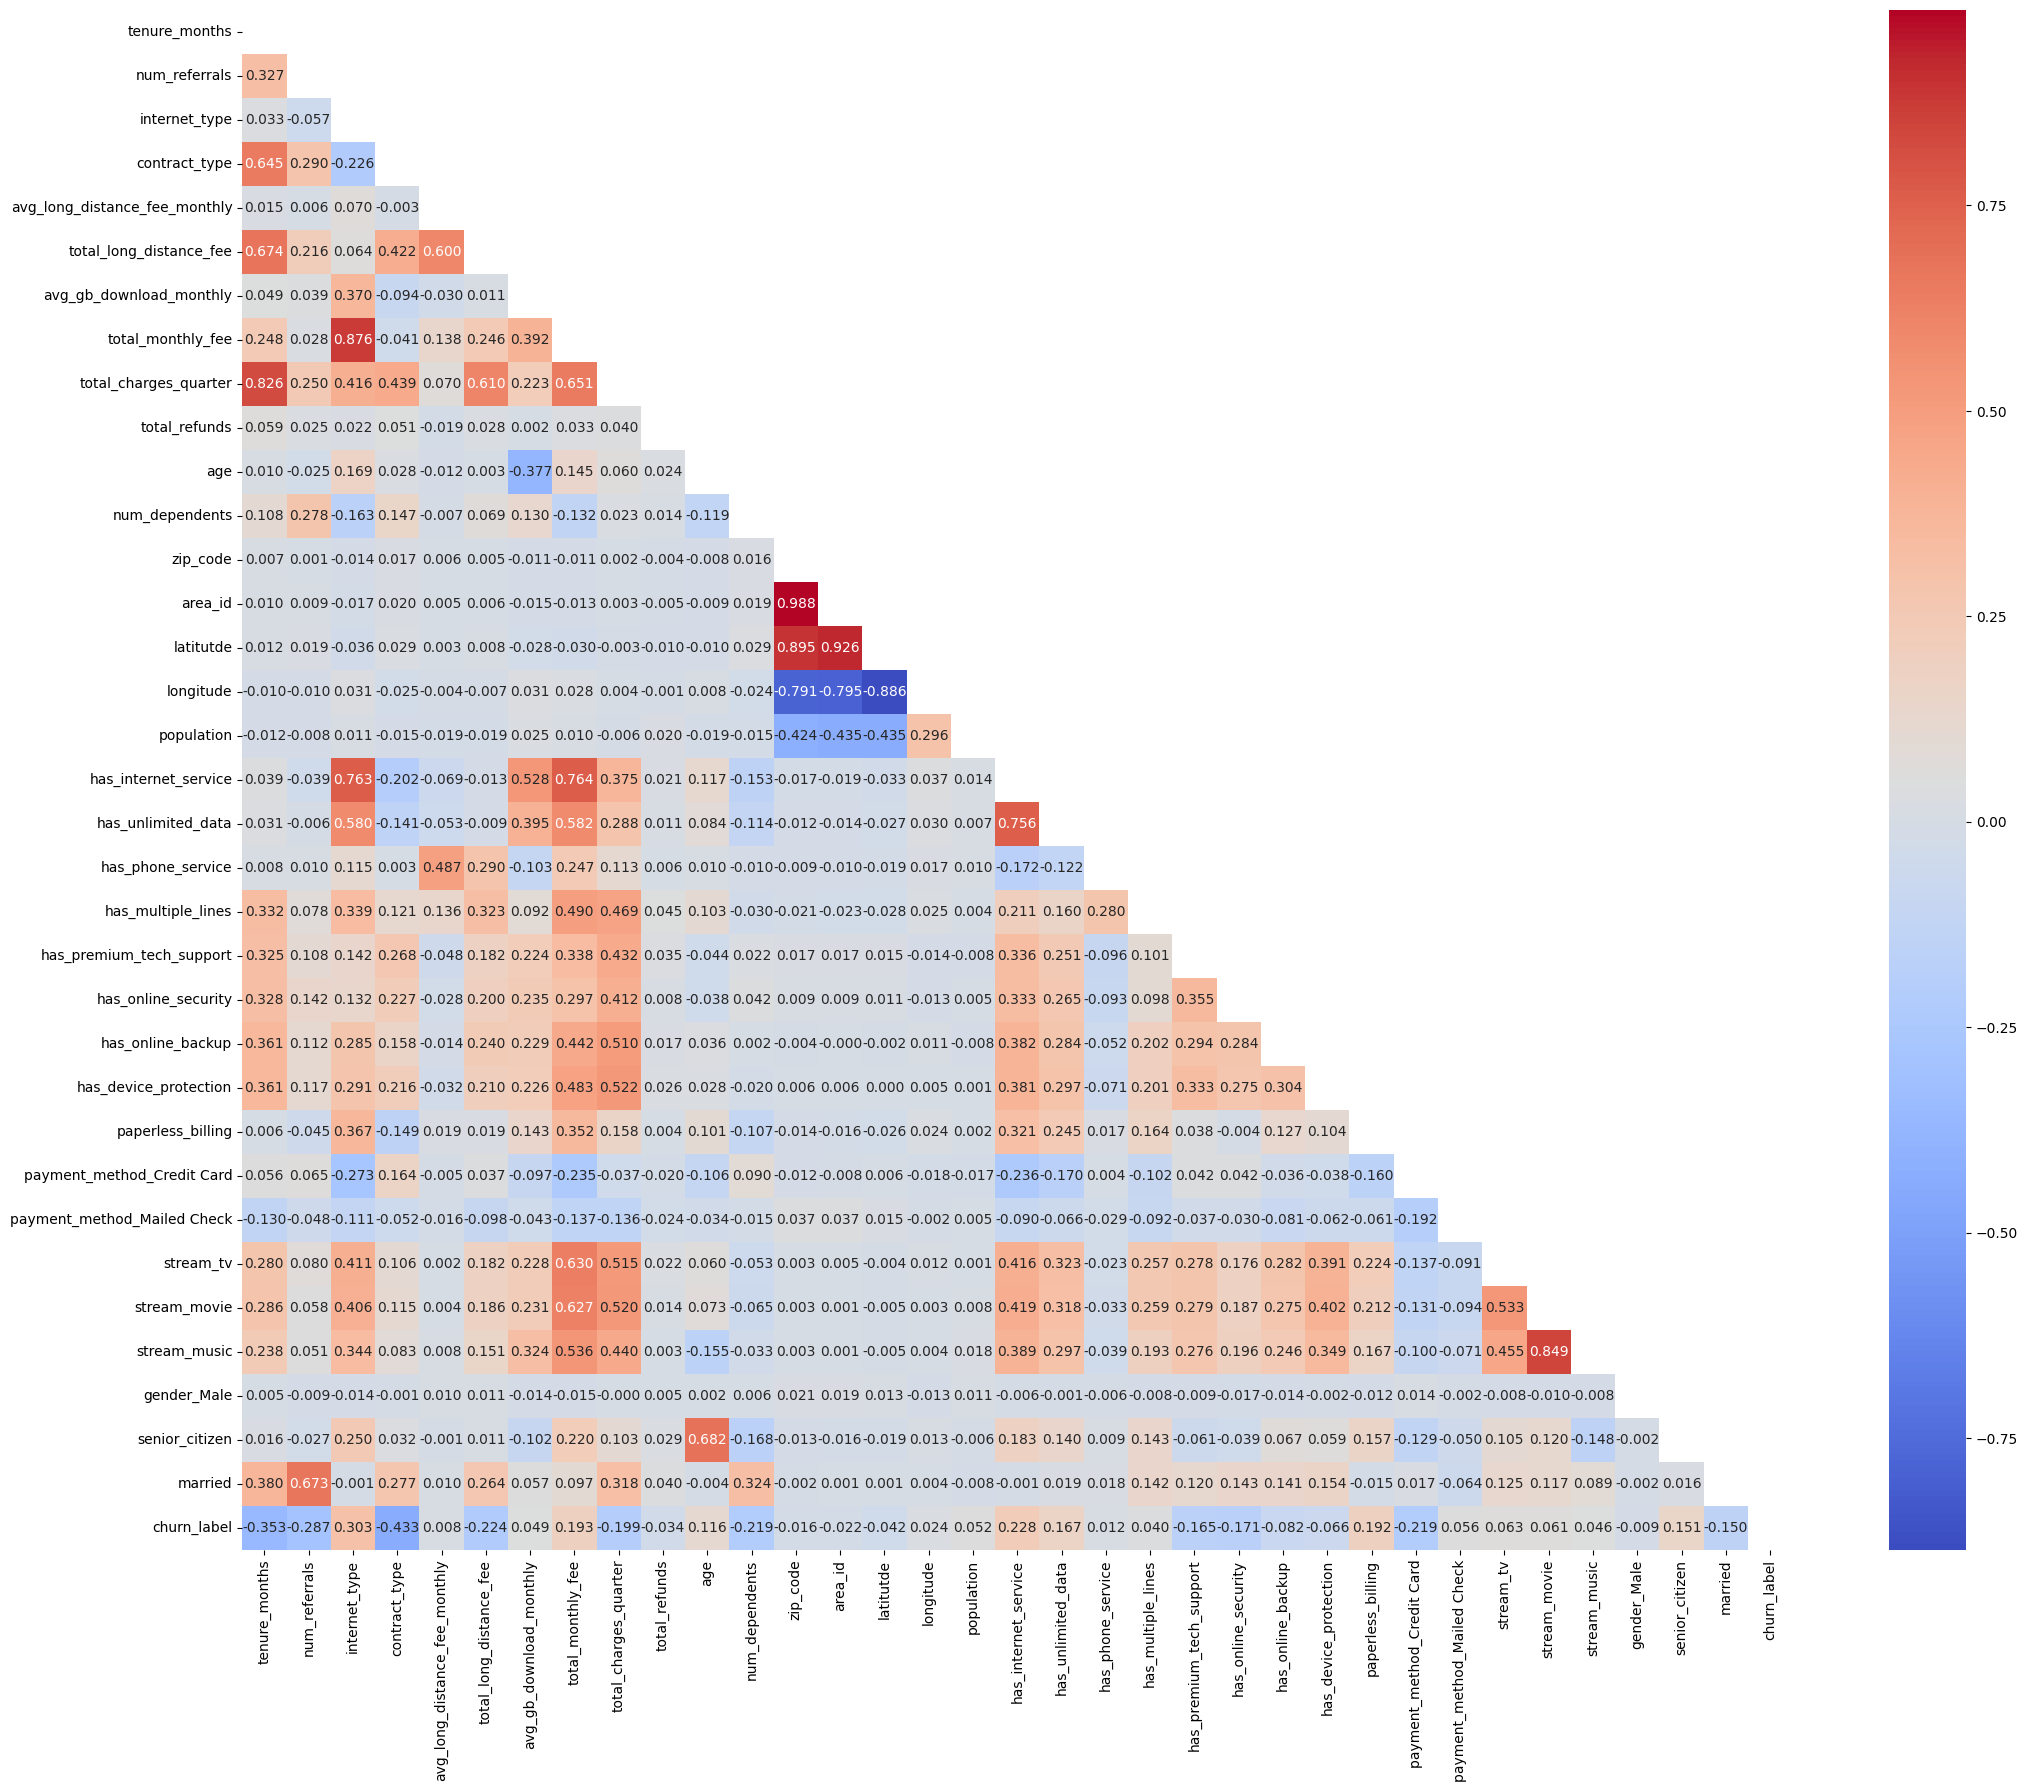

In [16]:
plt.figure(figsize=(25,20))
corr = encoded_df.corr()
matrix = np.triu(corr)
sns.heatmap(corr, annot=True, mask= matrix, cmap='coolwarm', fmt=".3f")
plt.show()

High correlation of 2 or more independent variables leads to multicollinearity, which makes variables redundant, hard to interpret and creates a problem of overfitting model.

No single variable is highly correlated with the target variable `churn_label`. Key cluster with high correlation to note- area_id, zip_code, longitude and latitude

### **4.2 Visualisation of Dataset- Customer's relationship with Telco**
***

In [17]:
#split dataset into churn and non churn for better visualisation of the distribution of data.
churn_yes = encoded_df[encoded_df['churn_label'] == 1]
churn_no = encoded_df[encoded_df['churn_label'] == 0]

#### **`tenure_months`**
Number of months the customer has stayed with the company

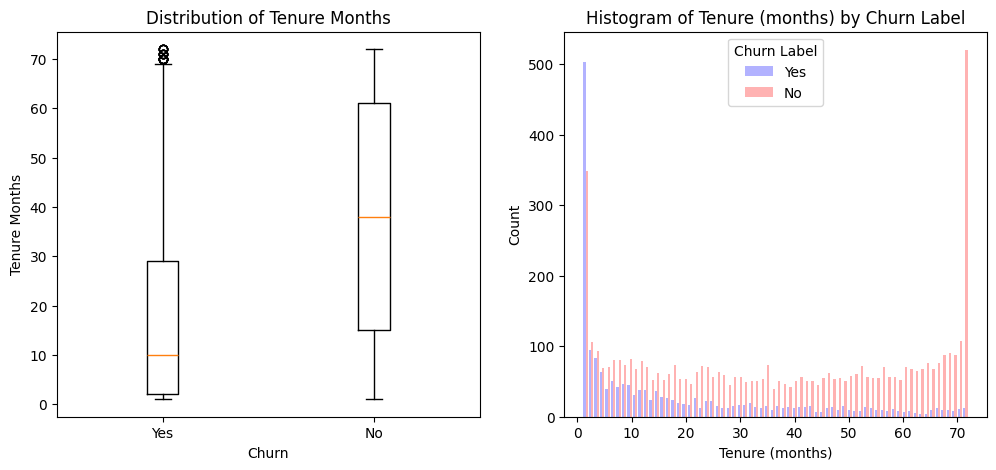

In [18]:
fig, (ax1, ax2)  = plt.subplots(1,2, figsize=(12,5))

ax1.boxplot([churn_yes['tenure_months'], churn_no['tenure_months']], tick_labels=['Yes', 'No'])
ax1.set_xlabel('Churn')
ax1.set_ylabel('Tenure Months')
ax1.set_title('Distribution of Tenure Months')

ax2.hist([churn_yes['tenure_months'], churn_no['tenure_months']], bins= 70, color=['blue', 'red'], alpha=0.3, label=['Yes', 'No'])
ax2.set_xlabel('Tenure (months)')
ax2.set_ylabel('Count')
ax2.set_title('Histogram of Tenure (months) by Churn Label')
ax2.legend(title ='Churn Label')

plt.show()

From these graphs, like most of the customers that are churning are on average 10 months with the telco as compared to those loyal customers- 40 months, this could be the result of high churn rates of those who just join the telco and high retention rates of customers towards the 70 months mark.

#### **`num_referrals`**
Number of referrals made by the customer

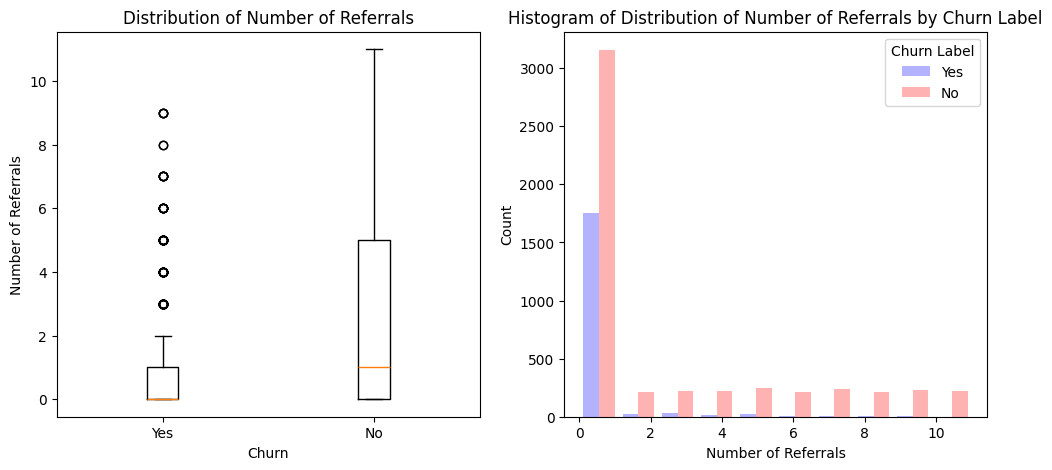

In [19]:
fig, (ax1, ax2)  = plt.subplots(1,2, figsize=(12,5))

ax1.boxplot([churn_yes['num_referrals'], churn_no['num_referrals']], tick_labels=['Yes', 'No'])
ax1.set_xlabel('Churn')
ax1.set_ylabel('Number of Referrals')
ax1.set_title('Distribution of Number of Referrals')

ax2.hist([churn_yes['num_referrals'], churn_no['num_referrals']], bins= 10, color = ['blue', 'red'], alpha = 0.3, label = ['Yes', 'No'])
ax2.set_xlabel('Number of Referrals')
ax2.set_ylabel('Count')
ax2.set_title('Histogram of Distribution of Number of Referrals by Churn Label')
ax2.legend(title ='Churn Label')

plt.show()

#### **`avg_long_distance_fee_monthly`**, **`total_long_distance_fee`**, **`avg_gb_download_monthly`**, **`total_monthly_fee`**, **`total_charges_quarter`** and **`total_refunds`**

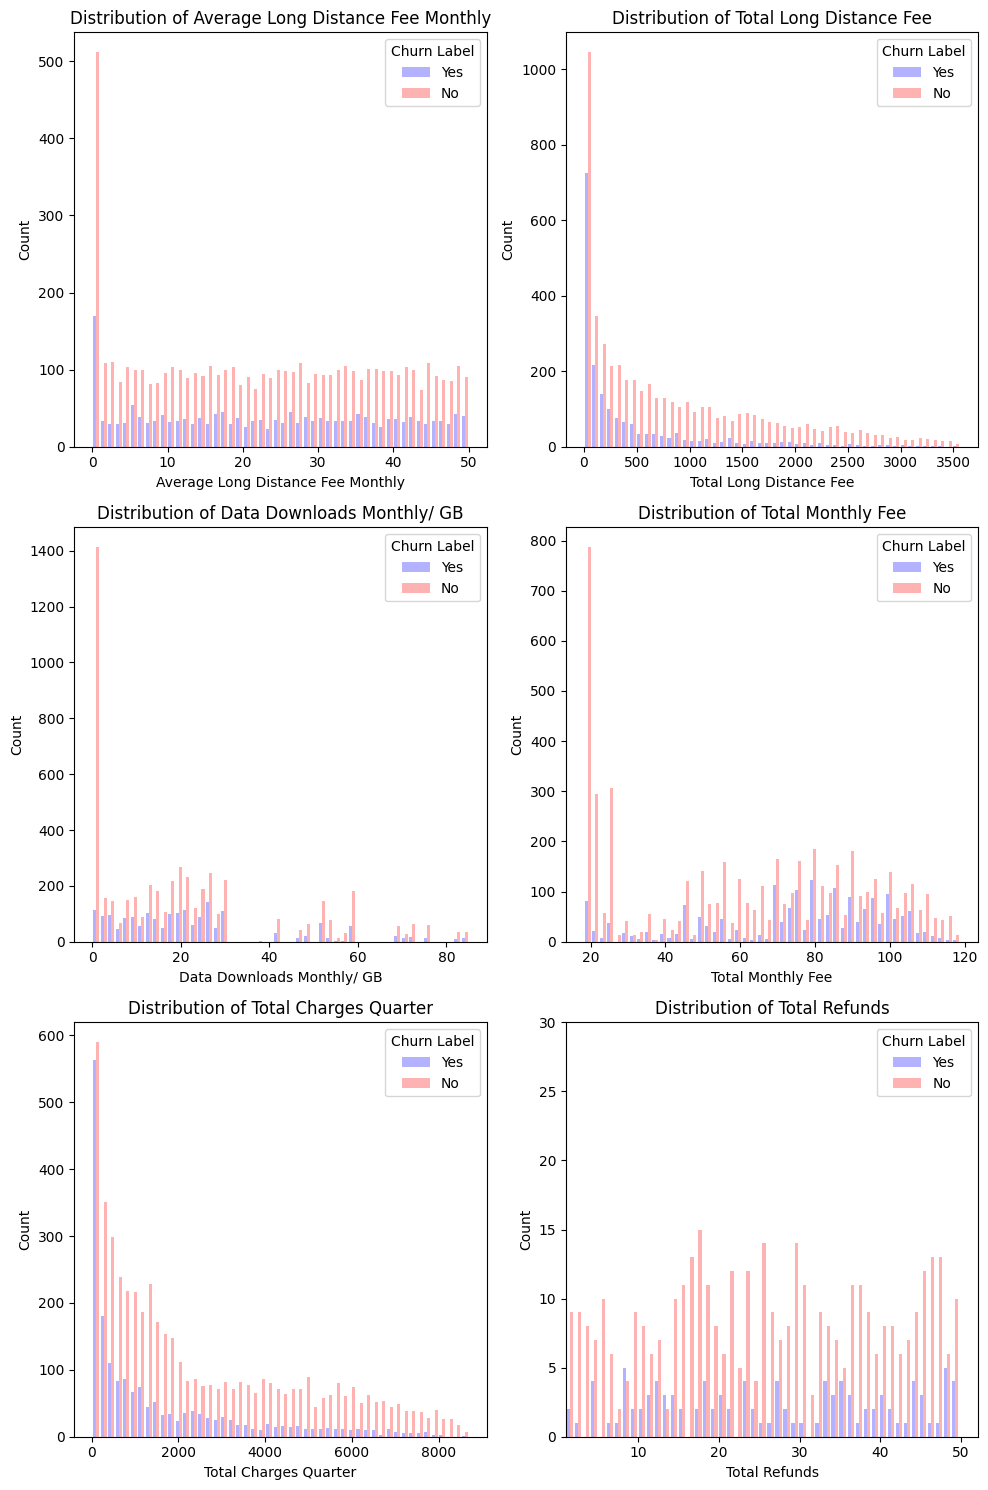

In [20]:
fees_columns = [
    ('avg_long_distance_fee_monthly', 'Average Long Distance Fee Monthly'),
    ('total_long_distance_fee', 'Total Long Distance Fee'),
    ('avg_gb_download_monthly', 'Data Downloads Monthly/ GB'),
    ('total_monthly_fee', 'Total Monthly Fee'),
    ('total_charges_quarter', 'Total Charges Quarter'),
    ('total_refunds', 'Total Refunds')
]

# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(10,15))
axes = axes.flatten()

for i, (col, xlabel) in enumerate(fees_columns):
    ax = axes[i]
    ax.hist([churn_yes[col], churn_no[col]], bins=50, color=['blue', 'red'], alpha=0.3, label=['Yes', 'No'])
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Count')
    ax.set_title(f'Distribution of {xlabel}')
    ax.legend(title= 'Churn Label')

axes[5].set_xlim(left=1)
axes[5].set_ylim(top=30)

plt.tight_layout()
plt.show()

#### **`has_internet_service`** and **`internet_type`**

correlation between the 2 variable = 1. Hence, will proceed to drop `has_internet_service` column to avoid overfitting model as `internet_type` contains more information which might be helpful.

In [21]:
encoded_df.drop(['has_internet_service'], axis = 1, inplace = True)

#### **`internet_type`**, **`contract_type`**, **`has_unlimited_data`** , **`has_phone_service`**, **`has_multiple_lines`**, **`has_premium_tech_support`**, **`has_online_security`**,**`has_online_backup`**, **`has_device_protection`**, **`paperless_billing`**, **`payment_method`**, **`stream_tv`**, **`stream_movie`**, **`stream_music`**

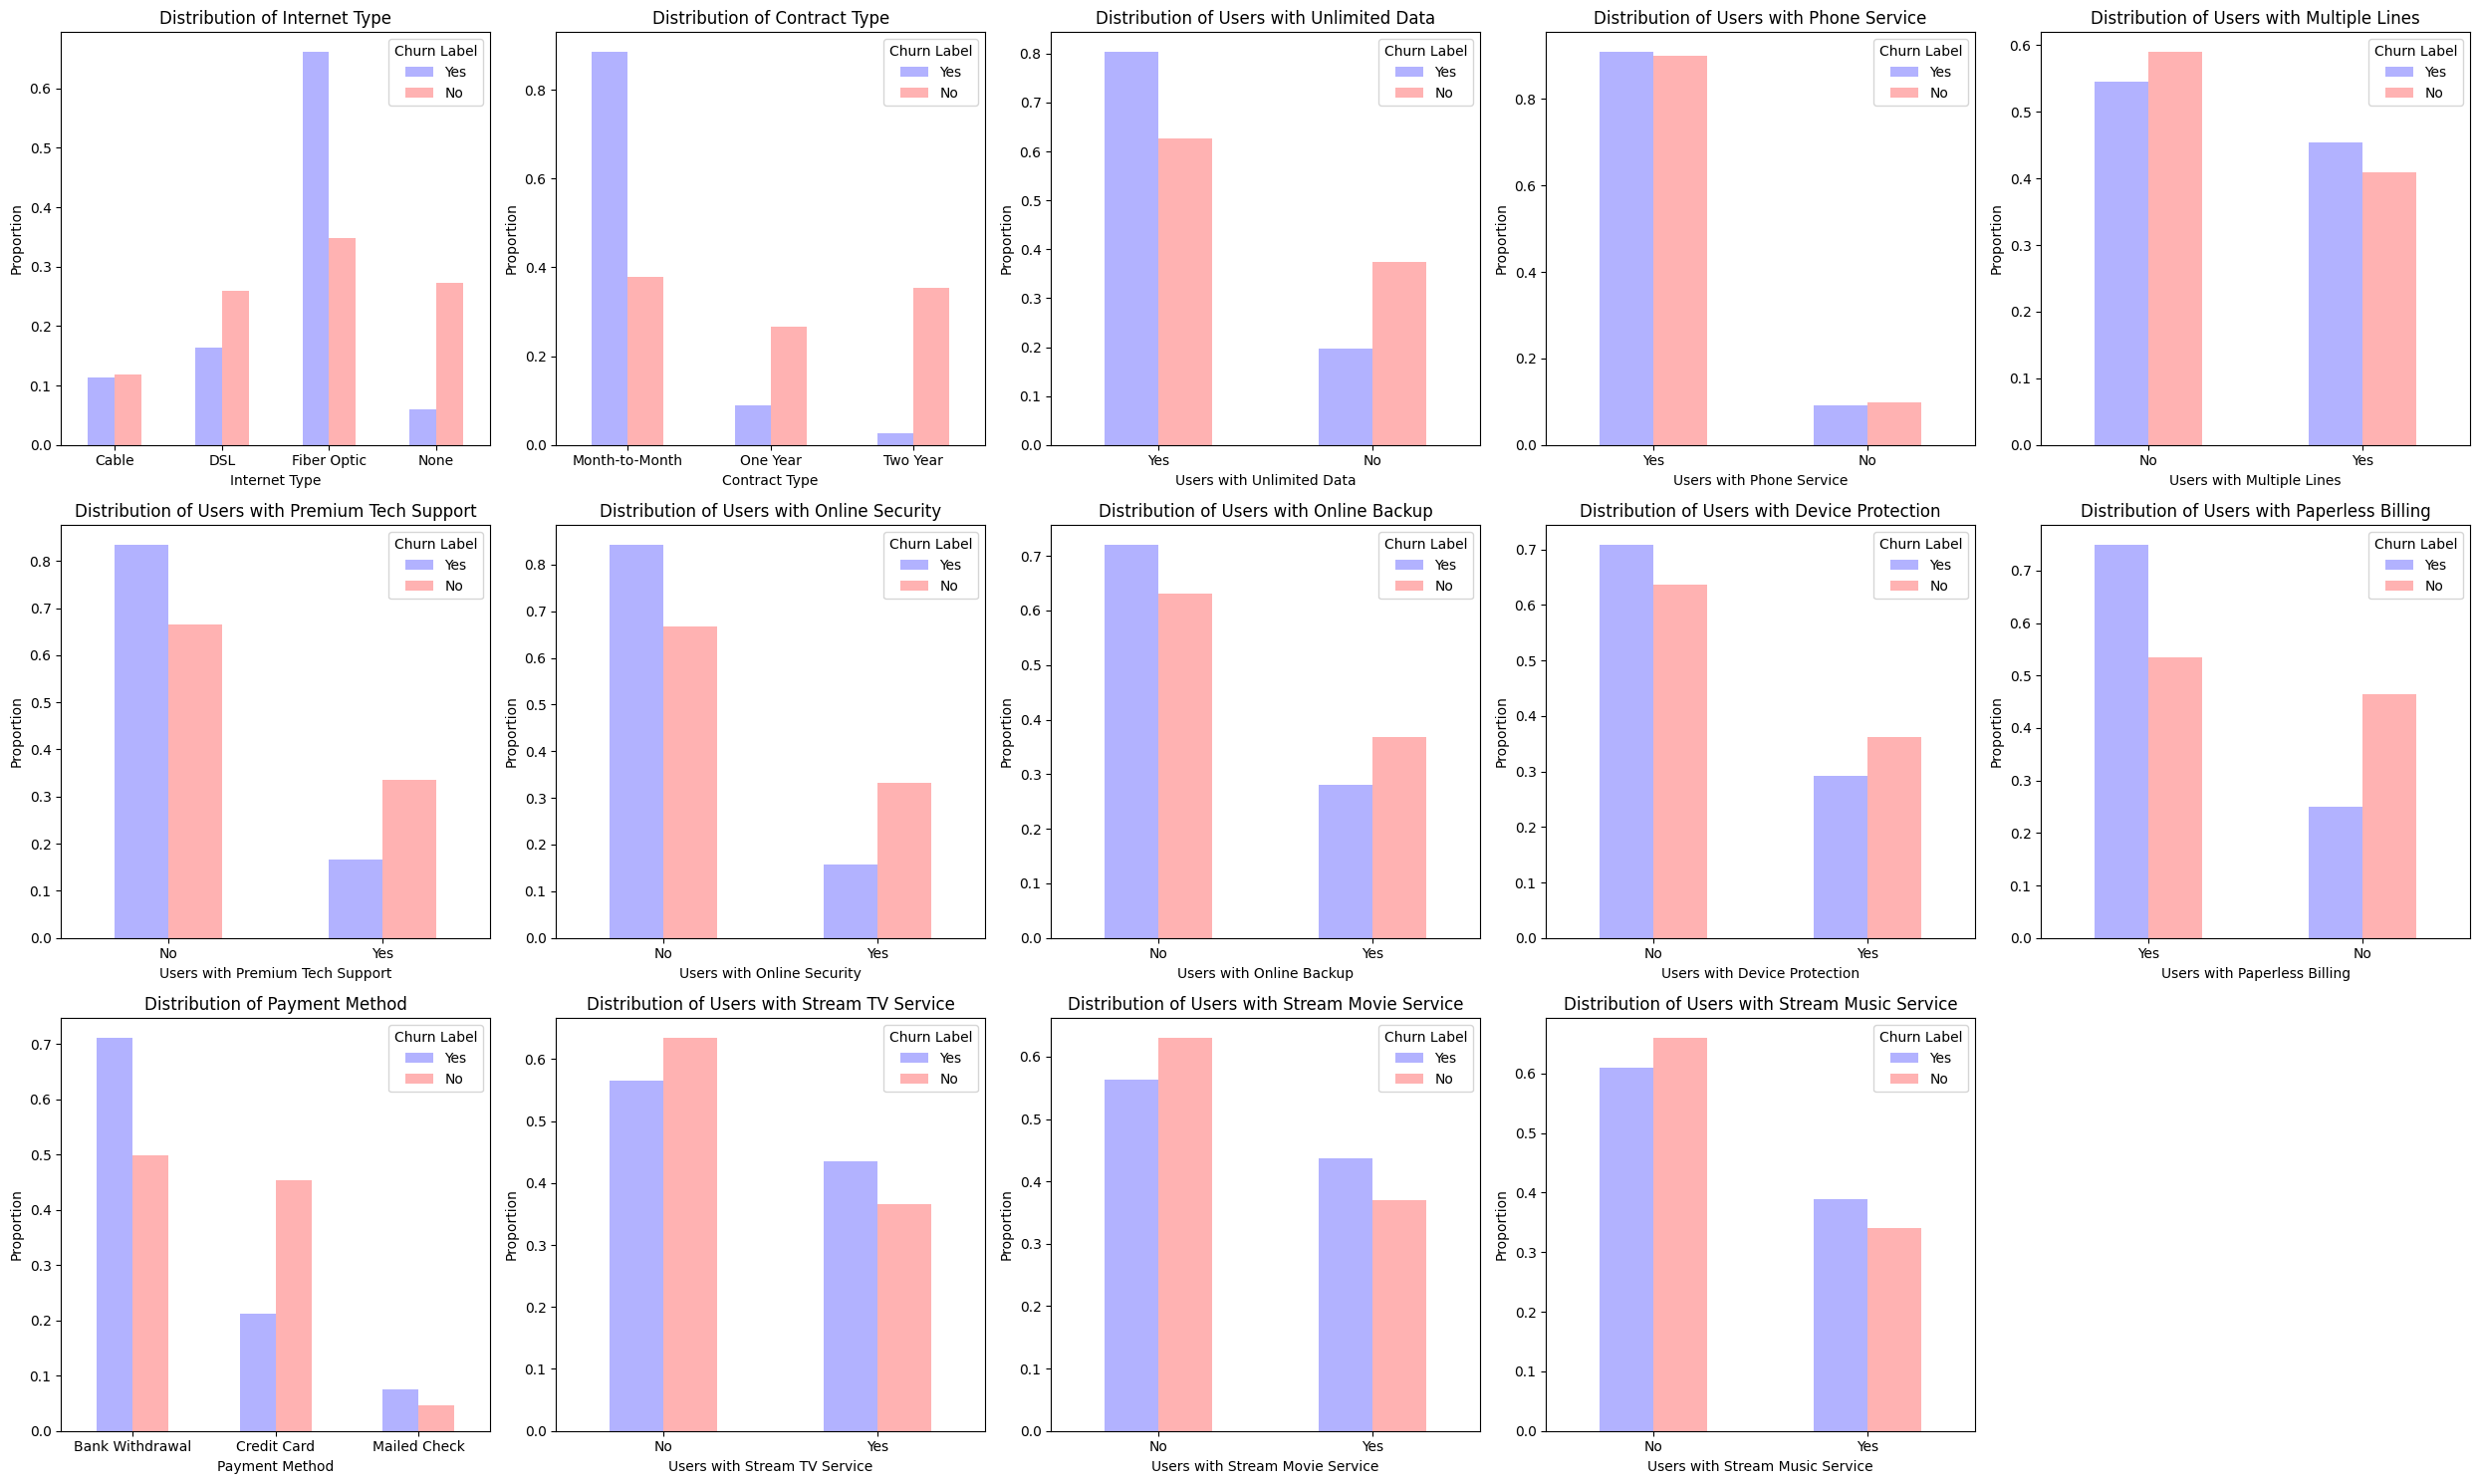

In [22]:
services_columns = [
    ('internet_type', 'Internet Type'), 
    ('contract_type', 'Contract Type'),
    ('has_unlimited_data', 'Users with Unlimited Data'),
    ('has_phone_service', 'Users with Phone Service'),
    ('has_multiple_lines', 'Users with Multiple Lines'),
    ('has_premium_tech_support', 'Users with Premium Tech Support'),
    ('has_online_security','Users with Online Security'),
    ('has_online_backup', 'Users with Online Backup'),
    ('has_device_protection', 'Users with Device Protection'),
    ('paperless_billing', 'Users with Paperless Billing'),
    ('payment_method', 'Payment Method'),
    ('stream_tv','Users with Stream TV Service'),
    ('stream_movie', 'Users with Stream Movie Service'),
    ('stream_music','Users with Stream Music Service'),
]

# Create subplots
fig, axes = plt.subplots(3, 5, figsize=(25, 15))
axes = axes.flatten()

for i, (col, xlabel) in enumerate(services_columns):
    ax = axes[i]
    yes_counts = churn_df[churn_df['churn_label']=="Yes"][col].value_counts(normalize= True)
    no_counts = churn_df[churn_df['churn_label']=="No"][col].value_counts(normalize= True)
    
    # Combine the counts into a dataframe for easier plotting
    df_counts = pd.DataFrame({'Yes': yes_counts, 'No': no_counts}).fillna(0)
    df_counts.plot(kind='bar', ax=ax, color=['blue', 'red'], alpha=0.3)
    ax.set_xlabel(xlabel)
    ax.tick_params(axis='x', labelrotation=0)
    ax.set_ylabel('Proportion')
    ax.set_title(f'Distribution of {xlabel}')
    ax.legend(title= 'Churn Label')

axes[-1].axis('off')

plt.tight_layout()
plt.show()

Customers with fibre optic internet type tends to churn more than compared to the rest of the internet types
Those on month-to-month contract types also tend to churn more than the other contract types.
Next, those with bank withdrawal payment method has a higher churn rate than the rest of the payment methods.ModuleNotFoundError

### **4.3 Visualisation of Dataset- Demographic Information**

#### **`senior_citizen`**, **`age`**, **`married`** and **`num_dependents`**

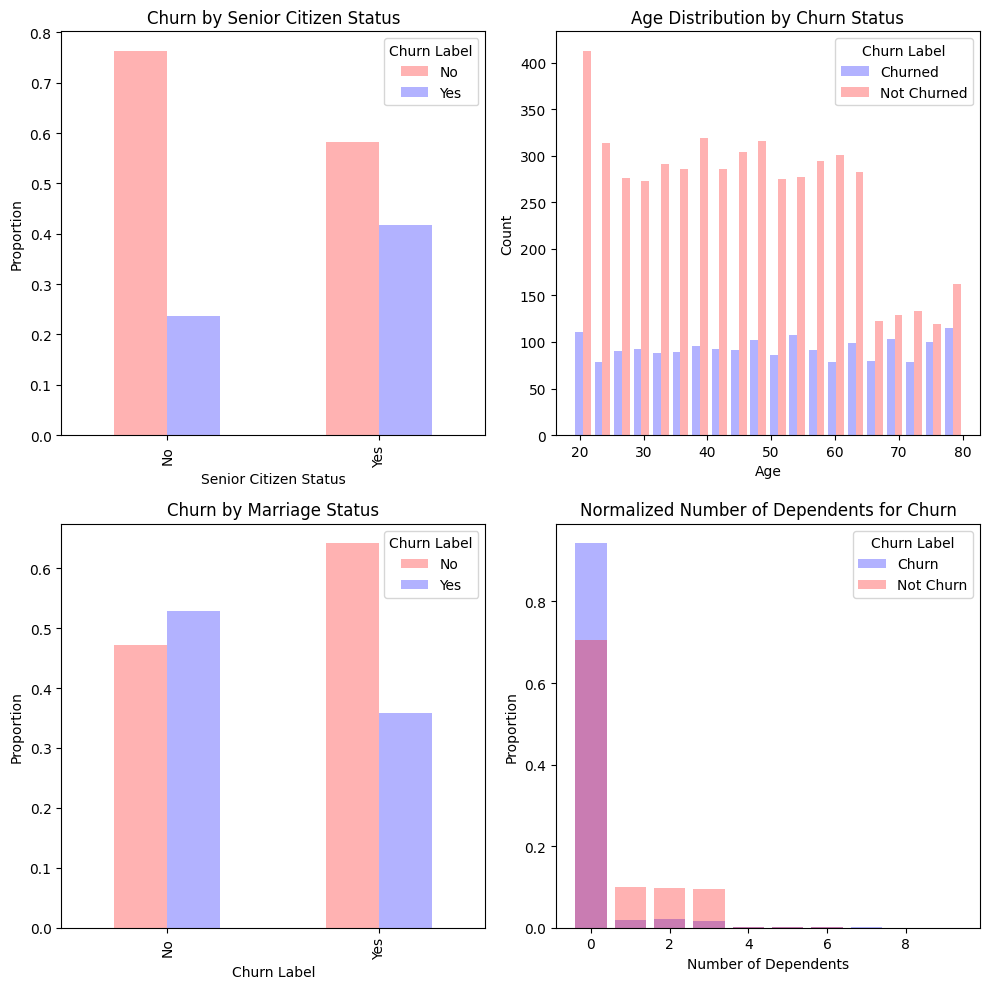

In [23]:
# Create the subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))

churn_by_senior = pd.crosstab(churn_df['senior_citizen'], churn_df['churn_label'], normalize='index')
churn_by_senior.plot(kind='bar', ax=ax1, color=['red', 'blue'], alpha = 0.3)
ax1.set_title('Churn by Senior Citizen Status')
ax1.set_xlabel('Senior Citizen Status')
ax1.set_ylabel('Proportion')
ax1.legend(title= 'Churn Label')

ax2.hist([churn_yes['age'], churn_no['age']], bins=20, color=['blue', 'red'], label=['Churned','Not Churned'], alpha=0.3)
ax2.set_title('Age Distribution by Churn Status')
ax2.set_xlabel('Age')
ax2.set_ylabel('Count')
ax2.legend(title= 'Churn Label')

churn_by_married = pd.crosstab(churn_df['churn_label'], churn_df['married'], normalize='index')
churn_by_married.plot(kind='bar', ax=ax3, color=['red', 'blue'], alpha = 0.3)
ax3.set_title('Churn by Marriage Status')
ax3.set_xlabel('Churn Label')
ax3.set_ylabel('Proportion')
ax3.legend(title= 'Churn Label')

ax4.bar(churn_yes['num_dependents'].unique(), list(churn_yes['num_dependents'].value_counts(normalize=True)), label='Churn', color = 'blue', alpha =0.3)
ax4.bar(churn_no['num_dependents'].unique(), list(churn_no['num_dependents'].value_counts(normalize=True)), label='Not Churn', color = 'red', alpha =0.3)
ax4.set_xlabel('Number of Dependents')
ax4.set_ylabel('Proportion')
ax4.set_title('Normalized Number of Dependents for Churn')
ax4.legend(title= 'Churn Label')

plt.tight_layout()
plt.show()


#### **`area_id`, `zip_code`, `latitude`, `longitude` and `population`** of the area

As observed in the correlation table, these details are all correlated and these redundant features can can lead to overfitting of ML models. In this case, we will leave `area_id`(TBC)

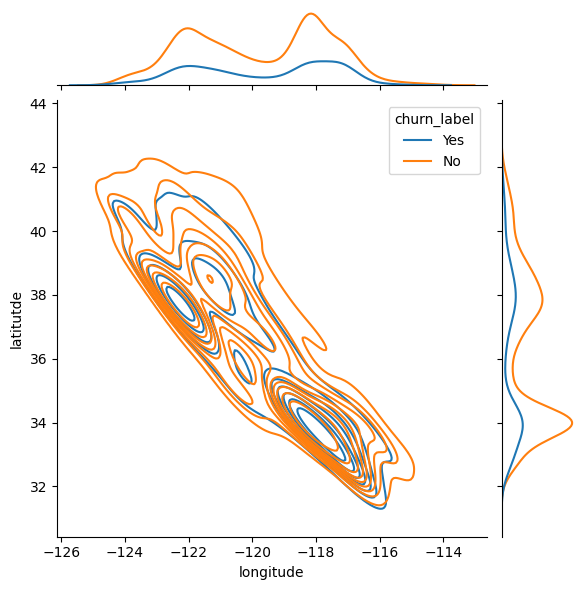

In [24]:
sns.jointplot(
    data=churn_df,
    x='longitude', y='latitutde', hue="churn_label",
    kind="kde"
)

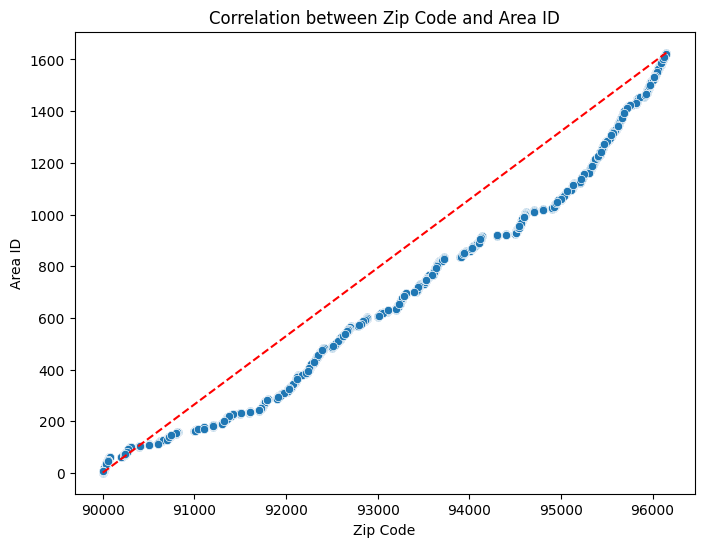

In [25]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='zip_code', y='area_id', data=churn_df)

plt.plot([churn_df['zip_code'].min(), churn_df['zip_code'].max()], 
         [churn_df['area_id'].min(), churn_df['area_id'].max()], 
         color='red', linestyle='--')

plt.title('Correlation between Zip Code and Area ID')
plt.xlabel('Zip Code')
plt.ylabel('Area ID')
plt.show()

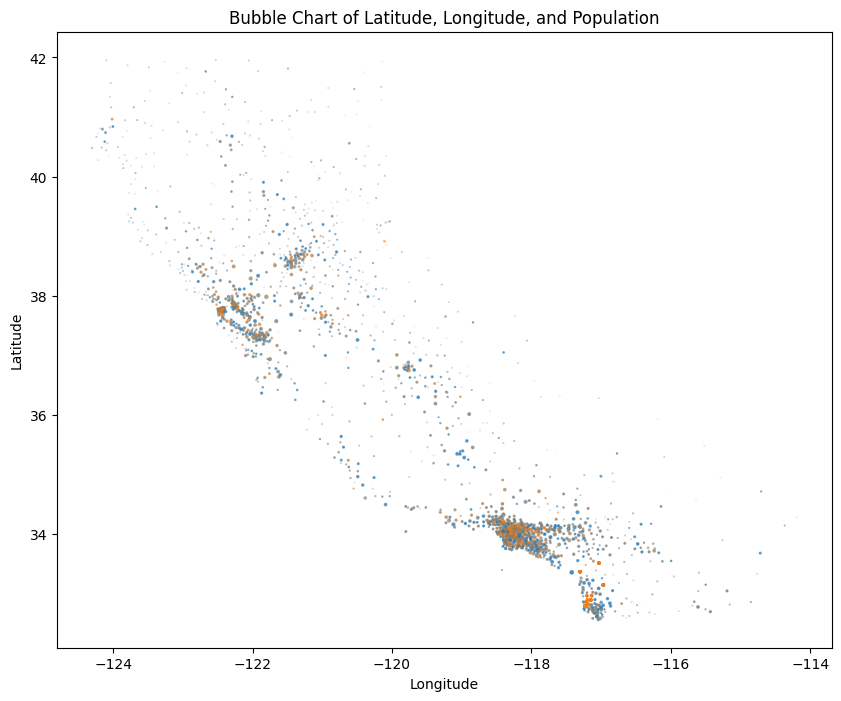

In [26]:
plt.figure(figsize=(10, 8))
plt.scatter(churn_no['longitude'], churn_no['latitutde'], s=churn_no['population']*0.00005, alpha=0.2)
plt.scatter(churn_yes['longitude'], churn_yes['latitutde'], s=churn_yes['population']*0.00005, alpha=0.2)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Bubble Chart of Latitude, Longitude, and Population')
plt.show()

`zip_code` are typically used for mail delivery purposes and can cover smaller or more specific geographic regions than area codes, which are primarily used for telephone communications.
Proceed to drop zipcode in this instance. Since `population` does not affect the `churn rate`, and `latitude` and `longitude` values are closely correlated with `area_id`, will proceed to drop these values.

In [27]:
encoded_df.drop(['zip_code', 'population', 'latitutde', 'longitude'], axis = 1, inplace = True)

### **5. Model Building and Evaluation**
***

In [28]:
X= encoded_df[[
       'tenure_months', 'num_referrals', 'avg_long_distance_fee_monthly',
       'total_long_distance_fee', 'avg_gb_download_monthly',
       'total_monthly_fee', 'total_charges_quarter', 'total_refunds', 
       'age','num_dependents', 'area_id', 'internet_type', 'has_unlimited_data', 
       'has_phone_service',
       'has_multiple_lines', 'has_premium_tech_support', 'has_online_security', 
       'has_online_backup', 'has_device_protection', 'contract_type', 
       'paperless_billing', 'payment_method_Credit Card', 'payment_method_Mailed Check',
       'stream_tv', 'stream_movie', 'stream_music', 
       'gender_Male', 'senior_citizen', 'married']]
y= encoded_df['churn_label']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state=42)
log_model = LogisticRegression(max_iter=10000, random_state=42)
log_model.fit(X_train, y_train)
y_pred = log_model.predict(X_test)
y_prob = log_model.predict_proba(X_test)[:, 1]

print('For Logistic Regression Model, these are the evaluation metrics:')
print("Accuracy score: {:.3f}".format(accuracy_score(y_test, y_pred)))
print("F1 score: {:.3f}".format(f1_score(y_test, y_pred)))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_test, y_prob)))

For Logistic Regression Model, these are the evaluation metrics:
Accuracy score: 0.841
F1 score: 0.684
ROC AUC: 0.895


In [29]:
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

print('For XGBoost Model, these are the evaluation metrics:')
print("Accuracy score: {:.3f}".format(accuracy_score(y_test, y_pred)))
print("F1 score: {:.3f}".format(f1_score(y_test, y_pred)))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_test, y_prob)))

For XGBoost Model, these are the evaluation metrics:
Accuracy score: 0.841
F1 score: 0.681
ROC AUC: 0.900


In [30]:
catboost_model = CatBoostClassifier(random_state=42, verbose=0)
catboost_model.fit(X_train ,y_train)
y_pred = catboost_model.predict(X_test)
y_prob = catboost_model.predict_proba(X_test)[:, 1]

print('For CatBoost Model, these are the evaluation metrics:')
print("Accuracy score: {:.3f}".format(accuracy_score(y_test, y_pred)))
print("F1 score: {:.3f}".format(f1_score(y_test, y_pred)))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_test, y_prob)))

For CatBoost Model, these are the evaluation metrics:
Accuracy score: 0.852
F1 score: 0.698
ROC AUC: 0.914


Since the best performing model is the Catboost model, we will proceed with hyperparameter tuning for the model.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state=42)
catboost_model = CatBoostClassifier(random_state=42, verbose=0)
param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [2, 4, 6]
}
grid_search_catboost = GridSearchCV(catboost_model, param_grid, cv=5, scoring='roc_auc')
grid_search_catboost.fit(X_train ,y_train)

best_params = grid_search_catboost.best_params_
best_estimator = grid_search_catboost.best_estimator_
y_pred = best_estimator.predict(X_test)
y_prob = best_estimator.predict_proba(X_test)[:, 1]
roc_auc= roc_auc_score(y_test, y_prob)

print('For CatBoost Model, these are the evaluation metrics:')
print("Accuracy score: {:.3f}".format(accuracy_score(y_test, y_pred)))
print("F1 score: {:.3f}".format(f1_score(y_test, y_pred)))
print("ROC AUC: {:.3f}".format(roc_auc))

For CatBoost Model, these are the evaluation metrics:
Accuracy score: 0.858
F1 score: 0.709
ROC AUC: 0.914


In [32]:
best_params

{'depth': 4, 'iterations': 300, 'learning_rate': 0.05}

#### **Visualising the ROC plot**

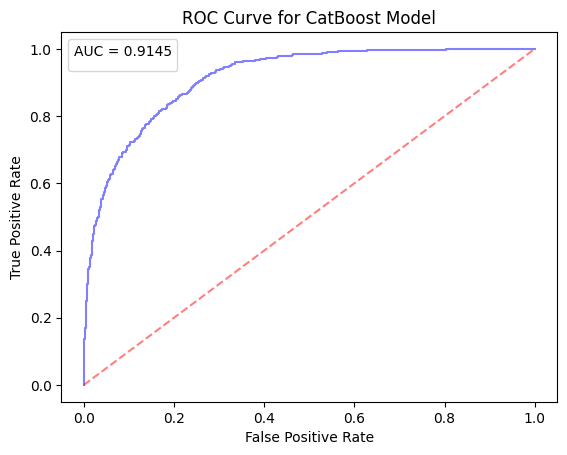

In [33]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_prob)
plt.plot(fpr,tpr, 'blue', alpha =0.5)
plt.plot([0, 1], [0, 1],'r--', alpha = 0.5)
plt.title('ROC Curve for CatBoost Model')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="upper left", title=f"AUC = {roc_auc:.4f}")
plt.show()

### **6. Model and Feature Selection + Serialising Model**
***

#### **Select First 10 Features for Final Model**

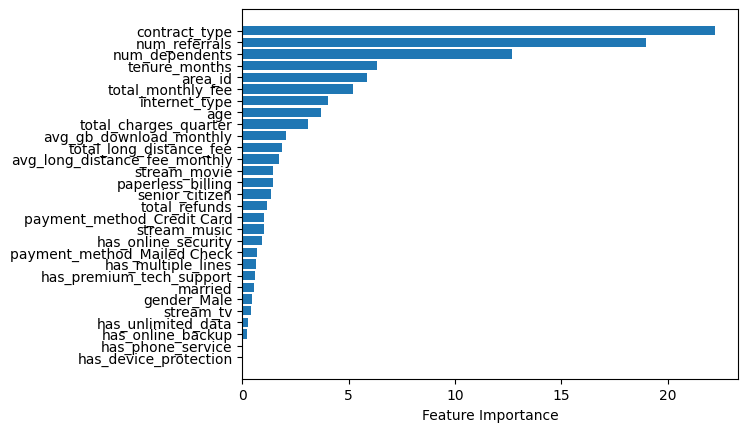

In [34]:
best_estimator.fit(X_train, y_train)
sort = best_estimator.feature_importances_.argsort()
plt.barh(X_train.columns.values[sort], best_estimator.feature_importances_[sort])

plt.xlabel("Feature Importance")
plt.show()

#### **Load Full Dataset Into Model**

In [36]:
X= encoded_df[[
    'contract_type', 'num_referrals', 'num_dependents', 'tenure_months',
    'area_id', 'total_monthly_fee', 'internet_type', 'age', 'total_charges_quarter',
    'avg_gb_download_monthly'
    ]]
y= encoded_df['churn_label']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state=42)
final_catboost_model = CatBoostClassifier(depth= 4, iterations= 300, learning_rate= 0.05, random_state=42, verbose=0)
final_catboost_model.fit(X_train, y_train)
y_pred = final_catboost_model.predict(X_test)
y_prob = final_catboost_model.predict_proba(X_test)[:, 1]

print('For the Final CatBoost Model, these are the evaluation metrics:')
print("Accuracy score: {:.3f}".format(accuracy_score(y_test, y_pred)))
print("F1 score: {:.3f}".format(f1_score(y_test, y_pred)))
print("ROC AUC: {:.3f}".format(roc_auc))

For the Final CatBoost Model, these are the evaluation metrics:
Accuracy score: 0.847
F1 score: 0.685
ROC AUC: 0.914


In [37]:
final_catboost_model.fit(X,y)

#### **Serialising Model**

In [38]:
Path("../model").mkdir(exist_ok=True)
joblib.dump(final_catboost_model, '../model/final1_catboost_model.pkl')

['../model/final1_catboost_model.pkl']